In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
# ถ้าไม่มี
# pip install beautifulsoup4
# pip install requests
# pip install tensorflow
# pip install pandas
# pip install seaborn
# pip install scikit-learn
# pip install folium

# error folium
# pip install MarkupSafe==2.0.1

In [9]:
import csv
import json
import os
import requests
import time

import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from keras import callbacks
from keras.models import load_model
import tensorflow as tf
from scipy import stats
from tensorflow.keras.layers import Bidirectional, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


In [10]:
# ต้องการไพล์ไหม ถ้าใช่เปลี่ยนเป็น True
request_data = False

In [11]:
# เก็บdata train
path = "RE1.1"

# **request_data**

In [12]:
def get_response_with_retry(url):
    while True:
        with requests.get(url) as response:
            if response.status_code in [502, 521]:
                print("Received 502, retrying in 5 seconds...")
                time.sleep(5)
                continue
            elif response.status_code == 200:
                return response
            else:
                print(f"Failed to download from {url}. Status code: {response.status_code}")
                return None

In [13]:
def create_csv_file(csv_filename, dustboy_lat, dustboy_lon, json_data):
    # สร้างcsv
    with open(csv_filename, mode="w", newline="") as csv_file:
        csv_writer = csv.writer(csv_file)

        # เขียนหัว
        csv_writer.writerow(["latitude", "longitude", "pm10", "pm25", "temp", "humid", "timestamp"])

        # ข้อมูลที่ใส่
        for entry in json_data["value"]:
            pm10 = entry.get("pm10", "")
            pm25 = entry.get("pm25", "")
            temp = entry.get("temp", "")
            humid = entry.get("humid", "")
            timestamp = entry.get("log_datetime", "")
            
            csv_writer.writerow([dustboy_lat, dustboy_lon, pm10, pm25, temp, humid, timestamp])

        print(f"CSV file '{csv_filename}' has been created.")

In [14]:
# READ ME
# แก้ csv_filename จาก RE1.1 เป็น name ของ directoryที่จะเก็บ

if request_data:
    # ดึง html
    url = "https://www.cmuccdc.org/download/"
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}
    response = requests.get(url=url, headers=headers)
    response.encoding = "utf-8"

    # เช็คว่าผ่านไหม
    if response.status_code == 200:
        print("Successful")
    elif response.status_code == 404:
        print("Error 404 page not found")
    else:
        print("Not both 200 and 404")

    raw_data = (BeautifulSoup(response.content, 'html.parser')).find('div', id='collapse0')

    # เอาแค่ส่วนเชียงใหม่
    if raw_data is not None:
        raw_data = raw_data.findAll("li", class_="mb-3")[6]
    else:
        print("Failed to find the specified div with id 'collapse0'. Exiting.")
        exit()

    # ดึงข้อมูลรายสถานี
    for idx, div in enumerate(raw_data.find_all('div', class_='station_list'), start=1):

        # เอาแค่ส่วนลิงค์
        link = div.find('a', class_='btn-secondary')['href']

        # เช็คว่ามีJSON ให้ดึงไหม
        response = get_response_with_retry(link)
        if response is not None:
            json_data = json.loads(response.text)
            print("JSON downloaded successfully")
        else:
            json_data = None
            print(f"No valid 'value' found in JSON data for {link} and {idx}. Skipping.")
            continue

        if json_data is not None and json_data.get("value") != []:
            dustboy_lat = json_data.get("dustboy_lat", "")
            dustboy_lon = json_data.get("dustboy_lon", "")
            csv_filename = f"{path}/data_{idx}.csv"
            create_csv_file(csv_filename, dustboy_lat, dustboy_lon, json_data)
        else:
            print(f"No valid 'value' found in JSON data for {link} and {idx}. Skipping.")

# **clear_data_sum_zero**

In [15]:
list_file = os.listdir(path)

In [16]:
def process_files_and_summary(path,list_file):

    count_delete = 0
    sum_df = 0

    for file_name in list_file:
        file_path = os.path.join(path, file_name)

        df = pd.read_csv(file_path)

        temp_sum = df["temp"].sum()
        humid_sum = df["humid"].sum()
        pm25_sum = df["pm25"].sum()
        pm10_sum = df["pm10"].sum()

        if temp_sum == 0 or humid_sum == 0:
            os.remove(file_path)
            count_delete += 1
        else:
            sum_df += len(df)

    print("#####################summary#####################")
    print(f"Total deleted files: {count_delete}")
    print(f"Remaining files in {path}: {len(os.listdir(path))}")
    print(f"Total remaining files rows: {sum_df}")


In [17]:
process_files_and_summary(path,list_file)
list_file = os.listdir(path)

#####################summary#####################
Total deleted files: 0
Remaining files in RE1.1: 12
Total remaining files rows: 105132


# **merged_data**


In [18]:
def merge_csv_files(path, list_file):
    dfs = []

    for file_name in list_file:
        file_path = os.path.join(path, file_name)
        df_temp = pd.read_csv(file_path)

        #แปลงเวลา และเรียงเวลาก่อนเก็บ 
        df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
        df_temp = df_temp.sort_values(by='timestamp')

        dfs.append(df_temp)

    df_append = pd.concat(dfs, ignore_index=True)

    output_path = "merged_data.csv"
    df_append.to_csv(output_path, index=False)

    print(f"Concatenated DataFrame saved to {output_path}")


In [19]:
merge_csv_files(path, list_file)

Concatenated DataFrame saved to merged_data.csv


# **map**

In [20]:
# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('merged_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [21]:
unique_space = df[['latitude','longitude']].drop_duplicates()

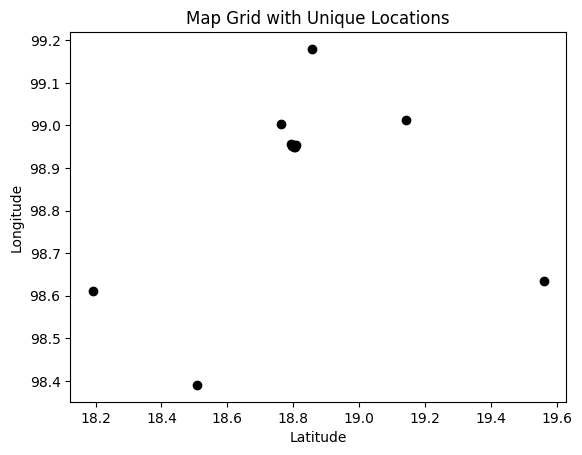

In [22]:
# Create a scatter plot
plt.scatter(unique_space['latitude'], unique_space['longitude'], marker='o', color='black', label='Locations')

# Add labels and title
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Map Grid with Unique Locations')
plt.show()

In [23]:
# มีจุดที่ไม่เกี่ยว อยู่ภาคใต้
for file_name in list_file:
    file_path = os.path.join(path, file_name)

    df = pd.read_csv(file_path)
    filtered_df = df[df['latitude'] < 10]

    if not filtered_df.empty:        
        os.remove(file_path)
        print(f"{file_name} has been removed.\n")
print('successfully')

list_file = os.listdir(path)

successfully


In [24]:
# in real-map
map_center = [df['latitude'].mean(), df['longitude'].mean()]
my_map = folium.Map(location=map_center, zoom_start=10)

# ถ้าต้องการทำกลุ่ม สร้างกลุ่มและใส่ลงmap ให้เปิดคอมเมน กับ ปิด my_map.add_child
# marker_cluster = MarkerCluster().add_to(my_map)

for lat, lon in zip(unique_space['latitude'], unique_space['longitude'] ):
    my_map.add_child(folium.Marker(location=[lat, lon], popup=f"{lat}, {lon}"))
    # folium.Marker(location=[lat, lon]).add_to(marker_cluster)

my_map

In [25]:
my_map.save('map_all.html')

# **EDA**

In [26]:
df = pd.read_csv('merged_data.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [27]:
df.head()

,latitude,longitude,pm10,pm25,temp,humid,timestamp
0,18.508792,98.390425,92.00,86.00,24.00,53.00,2023-01-30 00:00:00
1,18.508792,98.390425,92.00,86.00,23.50,54.00,2023-01-30 01:00:00
2,18.508792,98.390425,90.67,85.00,23.00,54.33,2023-01-30 02:00:00
3,18.508792,98.390425,88.00,82.33,22.33,55.33,2023-01-30 03:00:00
4,18.508792,98.390425,85.67,80.00,21.67,55.67,2023-01-30 04:00:00


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105132 entries, 0 to 105131
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   latitude   105132 non-null  float64       
 1   longitude  105132 non-null  float64       
 2   pm10       105132 non-null  float64       
 3   pm25       105132 non-null  float64       
 4   temp       105132 non-null  float64       
 5   humid      105132 non-null  float64       
 6   timestamp  105132 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6)
memory usage: 5.6 MB


In [29]:
df.describe()

,latitude,longitude,pm10,pm25,temp,humid,timestamp
count,105132.000000,105132.000000,105132.000000,105132.000000,105132.000000,105132.000000,105132
mean,18.819302,98.879093,45.210463,40.178506,31.024981,56.308578,2023-07-31 11:59:59.999999744
min,18.191708,98.390425,1.000000,1.000000,11.110000,14.590000,2023-01-30 00:00:00
25%,18.786383,98.870956,12.330000,9.670000,28.330000,44.330000,2023-05-01 06:00:00
50%,18.802316,98.952247,24.670000,21.170000,31.000000,54.760000,2023-07-31 12:00:00
75%,18.820608,98.968367,53.670000,46.330000,33.670000,66.000000,2023-10-30 18:00:00
max,19.559988,99.179698,351.040000,320.260000,44.580000,100.000000,2024-01-30 00:00:00
std,0.309689,0.209435,54.033848,49.869320,4.165482,16.414311,NaN


In [30]:
df.isnull().sum()

latitude     0
longitude    0
pm10         0
pm25         0
temp         0
humid        0
timestamp    0
dtype: int64

In [31]:
df.duplicated().sum()

0

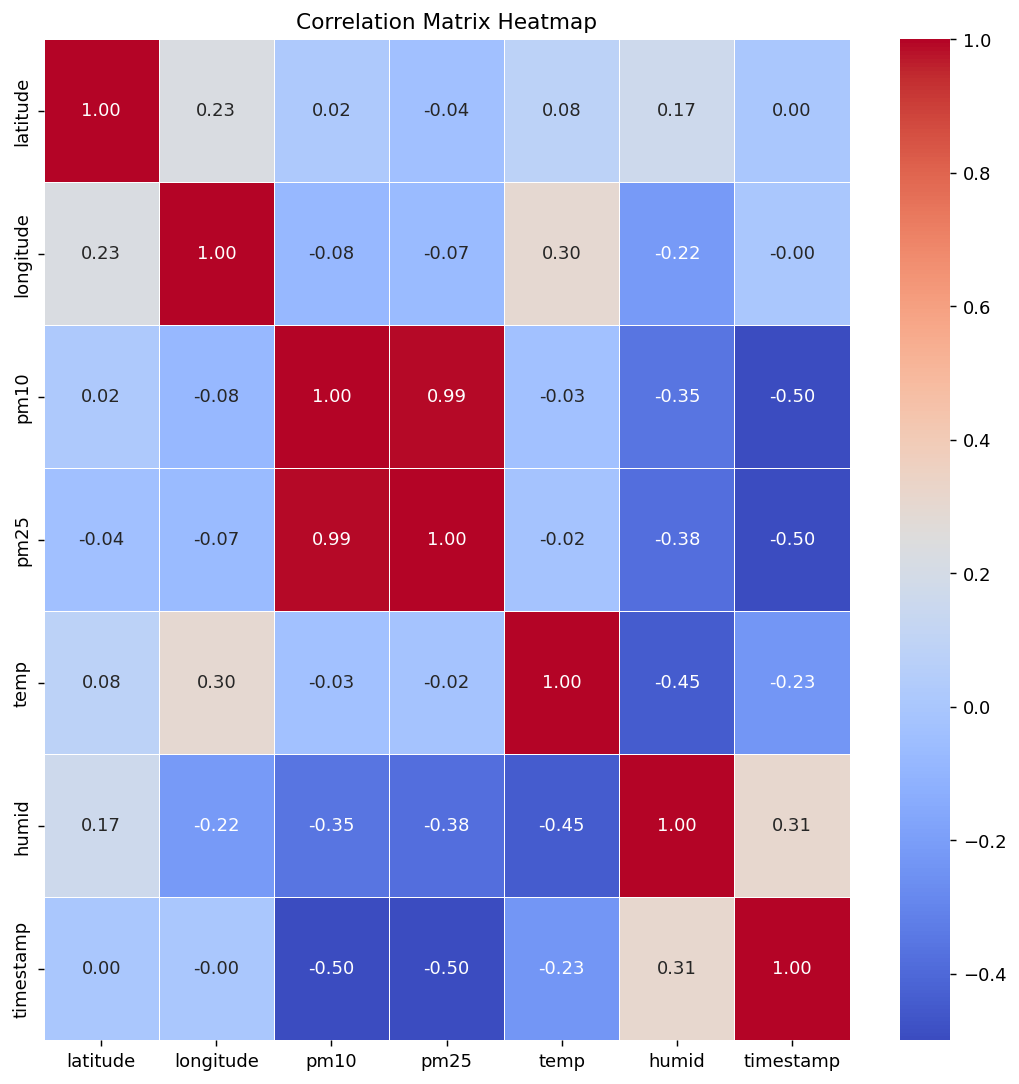

In [32]:
corr = df.corr()
# Create a heatmap
plt.figure(figsize=(10, 10),dpi=130)
sns.heatmap(corr, annot=True, fmt=".2f",cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

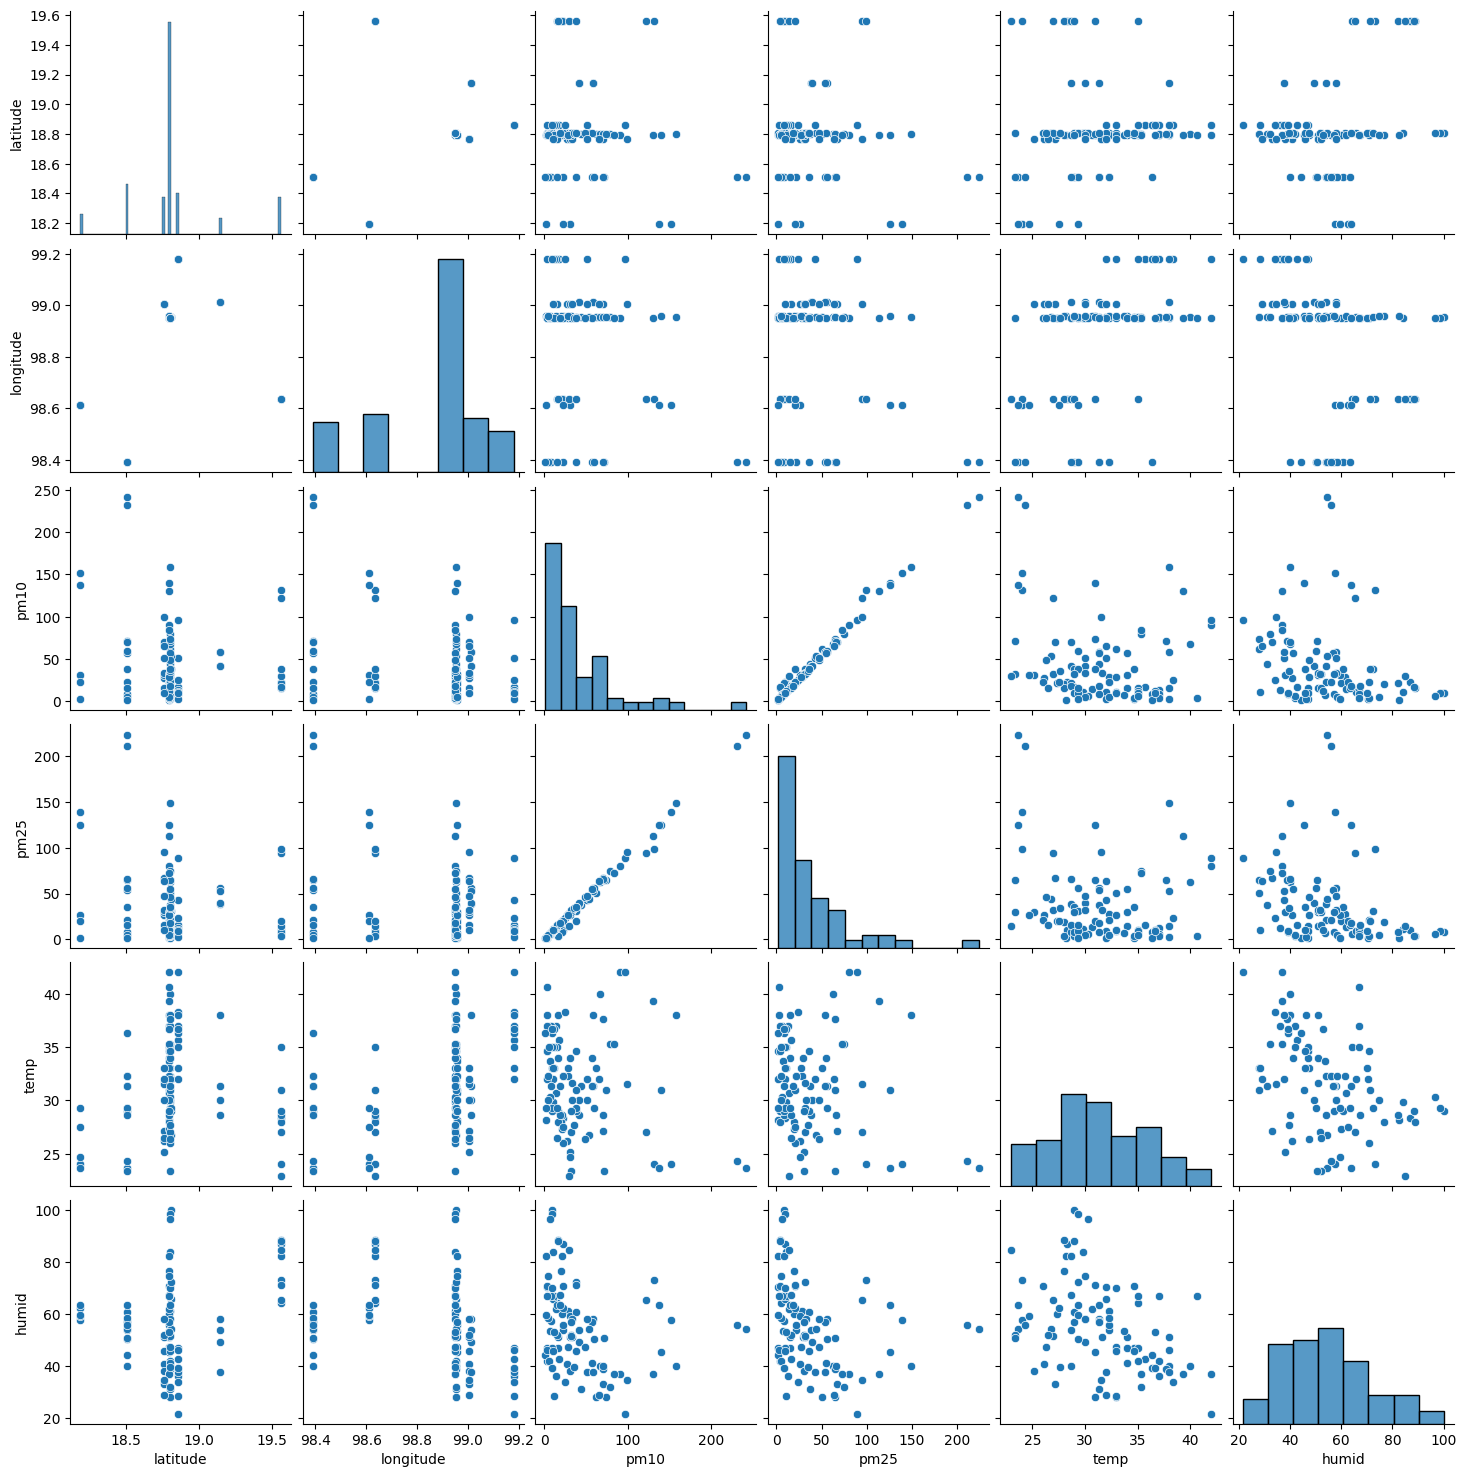

In [33]:
df_sample = df.sample(100)
sns.pairplot(df_sample)
plt.show()

# **data_preprocessing**

# **data_pre (หยาบๆๆ)**

เช็คว่า หายไปเท่าไหร่กับอยู่ในช่วงไหม (setหายที่<5%)

In [34]:
comparison_value_start = pd.to_datetime('2023-01-30 00:00:00', format='%Y-%m-%d %H:%M:%S')
comparison_value_end = pd.to_datetime('2024-01-30 00:00:00', format='%Y-%m-%d %H:%M:%S')

time_difference = comparison_value_end - comparison_value_start
result_in_hours = time_difference.total_seconds() / 3600 +1

print("Time Difference:", time_difference)
print("Result in Hours:", result_in_hours)

Time Difference: 365 days 00:00:00
Result in Hours: 8761.0


In [35]:
def find_lost_time(df_temp, start_time, end_time):

    df_temp = df_temp.copy()  # Make a copy of the DataFrame
    df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
    df_temp = df_temp.sort_values('timestamp')

    # Set latitude and longitude to the first entry's values
    default_latitude = df_temp.iloc[0]['latitude']
    default_longitude = df_temp.iloc[0]['longitude']

    # Ensure the time series starts from the specified start_time
    start_time = pd.to_datetime(start_time)
    if df_temp.iloc[0]['timestamp'] > start_time:
        new_time = start_time
        while new_time < df_temp.iloc[0]['timestamp']:
            new_row = {'latitude': default_latitude, 'longitude': default_longitude, 'pm10': '',
                       'pm25': '', 'temp': '', 'humid': '', 'timestamp': new_time}
            df_temp = pd.concat([pd.DataFrame(new_row, index=[0]), df_temp], ignore_index=True)
            new_time += pd.Timedelta(hours=1)
    
    # Ensure the time series ends at the specified end_time
    end_time = pd.to_datetime(end_time)
    if df_temp.iloc[-1]['timestamp'] < end_time:
        new_time = df_temp.iloc[-1]['timestamp'] + pd.Timedelta(hours=1)
        while new_time <= end_time:
            new_row = {'latitude': default_latitude, 'longitude': default_longitude, 'pm10': '',
                       'pm25': '', 'temp': '', 'humid': '', 'timestamp': new_time}
            df_temp = pd.concat([df_temp, pd.DataFrame(new_row, index=[0])], ignore_index=True)
            new_time += pd.Timedelta(hours=1)
    
    # Iterate over the rows in the DataFrame
    for i in range(len(df_temp)-1):
        current_time = df_temp.iloc[i]['timestamp']
        next_time = df_temp.iloc[i + 1]['timestamp']

        # Check if there is a gap of more than 1 hour between consecutive time values
        if (next_time - current_time) > pd.Timedelta(hours=1):
            # Insert missing time ranges with default latitude and longitude
            new_time = current_time + pd.Timedelta(hours=1)
            while new_time < next_time:
                new_row = {'latitude': default_latitude, 'longitude': default_longitude, 'pm10': '',
                           'pm25': '', 'temp': '', 'humid': '', 'timestamp': new_time}
                df_temp = pd.concat([df_temp, pd.DataFrame(new_row, index=[0])], ignore_index=True)
                new_time += pd.Timedelta(hours=1)

    # Sort the DataFrame again based on the 'timestamp' column
    df_temp.sort_values('timestamp', inplace=True)

    return df_temp


In [36]:
remove_file =  True
save_edited_file = True

In [37]:
count_rows = 0
count_file = 0
count_delete = 0
path = "RE1.1"

for file_name in list_file:
    file_path = os.path.join(path, file_name)
    df_temp = pd.read_csv(file_path)

    df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
    df_temp.sort_values('timestamp', inplace=True)
        
    # Filter DataFrame based on timestamp range
    filtered_df = df_temp[(df_temp['timestamp'] >= comparison_value_start) & (df_temp['timestamp'] <= comparison_value_end)]

    if (5 >= (((result_in_hours-len(filtered_df))*4)/(result_in_hours*7))*100):
        count_file += 1
        count_rows += len(filtered_df)

        if(save_edited_file):
            final_df = find_lost_time(filtered_df,comparison_value_start,comparison_value_end)
            final_df.to_csv(file_path, index=False)

    elif(remove_file):
        os.remove(file_path)
        count_delete += 1

list_file = os.listdir(path)

print("#####################summary#####################")
print(f"File_count: {count_file}, Rows_count: {count_rows}")
print(f"Rows_count_real: {result_in_hours*count_file}")
print(f"delete file: {count_delete}")

#####################summary#####################
File_count: 12, Rows_count: 105132
Rows_count_real: 105132.0
delete file: 0


In [38]:
process_files_and_summary(path,list_file)
list_file = os.listdir(path)

#####################summary#####################
Total deleted files: 0
Remaining files in RE1.1: 12
Total remaining files rows: 105132


In [39]:
merge_csv_files(path, list_file)

Concatenated DataFrame saved to merged_data.csv


# **data_pre(จริงๆละ)**

In [40]:
def clean_and_smooth_data(path, list_file, columns_to_smooth, window_size):

    for file_name in list_file:
        # Read CSV file into a DataFrame
        file_path = os.path.join(path, file_name)
        df_temp = pd.read_csv(file_path)

        # Convert timestamp to datetime and sort the dataframe
        df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
        df_temp = df_temp.sort_values(by='timestamp')

        # Handle missing values with linear interpolation
        df_temp.interpolate(method='linear', inplace=True, limit_direction='both')

        # Identify and handle outliers
        for column in columns_to_smooth:
            # Z-score based outlier detection
            z_scores = stats.zscore(df_temp[column])
            outlier_indices = np.where(np.abs(z_scores) > 3)[0]  # Threshold for outliers

            # Choose outlier treatment method (e.g., winsorization, imputation)
            # Here, we use winsorization to cap outliers to 3 standard deviations
            df_temp.loc[outlier_indices, column] = np.clip(df_temp.loc[outlier_indices, column],
                                                 df_temp[column].mean() - 3 * df_temp[column].std(),
                                                 df_temp[column].mean() + 3 * df_temp[column].std())
            
        # Apply moving average for smoothing
        for column in columns_to_smooth:
            df_temp[column] = df_temp[column].rolling(window=window_size, min_periods=1).mean()
            df_temp[column] = df_temp[column].round(2)  # Round to 2 decimal places

        # Output the cleaned dataframe to a new file
        df_temp.to_csv(file_path, index=False)


In [41]:
columns_to_smooth = ['pm10', 'pm25', 'temp', 'humid'] 
window_size = 3 
path = "RE1.1"

# clean_and_smooth_data(path, list_file, columns_to_smooth, window_size)

In [42]:
merge_csv_files(path, list_file)

Concatenated DataFrame saved to merged_data.csv


# **sprite_data**

In [43]:
def sprite_data(list_file, path, train_hour=6, test_hour=1, test_period=24, stride=1):
    df_x = []  # Use a list to store DataFrames
    df_y = []
    
    for file_name in list_file:
        file_path = os.path.join(path, file_name)
        df_temp = pd.read_csv(file_path)
        
        df_x.append(df_temp[['pm10',  'pm25',  'temp',  'humid']].to_numpy())
        df_y.append(df_temp[['pm10',  'pm25',  'temp',  'humid']].to_numpy())
    
    x, y = [], []
    period = train_hour + test_period + test_hour
    
    assert(stride != 0)  # Avoid infinite loop
    i = 0
    
    while i + period <= len(df_x[0]):
        x_temp = []
        y_temp = []
        
        for j in range(len(df_x)): # Loop through each sensor
            x_temp.append(np.array(df_x[j][i:i + train_hour]).flatten()) # Each line is from i : i+6
            y_temp.append(np.array(df_y[j][i + train_hour + test_period: i + train_hour + test_period + test_hour]).flatten())
        
        x.append(x_temp)
        y.append(y_temp)
        i += stride
    
    return np.array(x), np.array(y)

In [44]:
path = "RE1.1"

X_train, y_train = sprite_data(list_file, path, train_hour=6, test_hour=1, test_period=24, stride=1)

In [45]:
print(X_train.shape)
print(y_train.shape)

(8731, 12, 24)
(8731, 12, 4)


# **test_data**

In [46]:
validation_test_start = pd.to_datetime('2024-01-30 01:00:00', format='%Y-%m-%d %H:%M:%S')
validation_tes_tend = pd.to_datetime('2024-02-11 09:00:00', format='%Y-%m-%d %H:%M:%S')

time_difference_test = validation_tes_tend - validation_test_start
result_in_hours_test = time_difference_test.total_seconds() / 3600 +1

print("Time Difference:", time_difference_test)
print("Result in Hours:", result_in_hours_test)

Time Difference: 12 days 08:00:00
Result in Hours: 297.0


In [47]:
same_file = os.listdir("RE1.1")
list_file = os.listdir("RE1.2")

In [48]:
for file_name in list_file:
    file_path = os.path.join("RE1.2", file_name)
    if (file_name in same_file):
        df_temp = pd.read_csv(file_path)

        df_temp['timestamp'] = pd.to_datetime(df_temp['timestamp'])
        df_temp.sort_values('timestamp', inplace=True)
        filtered_df = df_temp[(df_temp['timestamp'] >= validation_test_start) & (df_temp['timestamp'] <= validation_tes_tend)]

        final_df = find_lost_time(filtered_df,validation_test_start,validation_tes_tend)
        final_df.to_csv(file_path, index=False)

    else:
        os.remove(file_path)

list_file = os.listdir("RE1.2")

In [49]:
columns_to_smooth = ['pm10', 'pm25', 'temp', 'humid'] 
window_size = 3 
path = "RE1.2"

clean_and_smooth_data(path, list_file, columns_to_smooth, window_size)

In [50]:
X_test, y_test = sprite_data(list_file, path, train_hour=6, test_hour=1, test_period=24, stride=1)

In [51]:
print(X_test.shape)
print(y_test.shape)

(267, 12, 24)
(267, 12, 4)


# **train_model**

In [52]:
time_step = X_train.shape[1]
input_dim =  X_train.shape[2]
out =  y_train.shape[2]

model = Sequential()
model.add(Bidirectional(LSTM(48,activation='relu', input_shape=(time_step, input_dim),return_sequences=True)))
model.add(Dense(out))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0003))
print(f'Data size for features {X_train.shape} and labels {y_train.shape}')
print(f'input shape = {X_train.shape}')
callback = callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1)

hist = model.fit(X_train, y_train,epochs=50, validation_split=.2,verbose=1, batch_size=12, callbacks=[callback],shuffle=False)

model.summary()

2024-04-17 15:56:37.519551: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-17 15:56:37.521469: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/dragon/miniconda3/envs/workspace/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Data size for features (8731, 12, 24) and labels (8731, 12, 4)
input shape = (8731, 12, 24)
Epoch 1/50


2024-04-17 15:56:37.763757: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8045568 exceeds 10% of free system memory.


582/582 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 1825.5811 - val_loss: 208.6212
Epoch 2/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 751.8621 - val_loss: 161.2487
Epoch 3/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 658.8027 - val_loss: 138.9485
Epoch 4/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 631.6578 - val_loss: 130.6737
Epoch 5/50
582/582 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 605.7527 - val_loss: 129.2094
Epoch 6/50
285/582 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 790.4196

KeyboardInterrupt: 

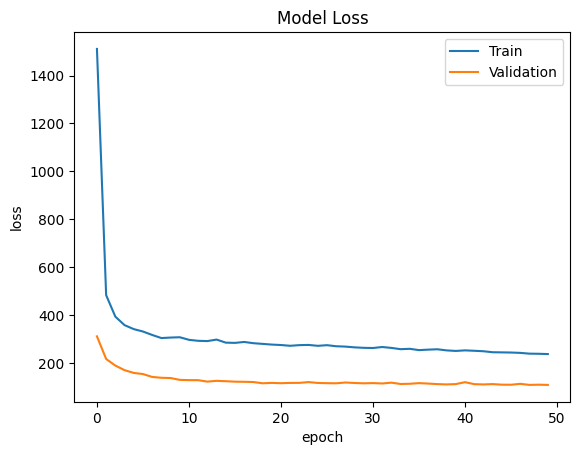

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
model.save("model/air_model.keras")

# **validation_test**

In [ ]:
model = load_model('model/air_model.keras')

In [ ]:
predictions = model.predict(X_test)

mae_per_feature_per_sensor = np.mean(np.abs(y_test - predictions), axis=0)
rmse_per_feature_per_sensor = np.sqrt(np.mean((y_test - predictions)**2, axis=0))

with open("error/error_metrics_1.txt", "w") as f:
    for i, (mae, rmse) in enumerate(zip(mae_per_feature_per_sensor, rmse_per_feature_per_sensor)):
        f.write(f"Sensor {i + 1} - Error Metrics per feature:\n")
        f.write(f"  PM10 MAE:       {mae[0]:.2f}   RMSE: {rmse[0]:.2f}\n")
        f.write(f"  PM25 MAE:       {mae[1]:.2f}   RMSE: {rmse[1]:.2f}\n")
        f.write(f"  Temperature MAE: {mae[2]:.2f}   RMSE: {rmse[2]:.2f}\n")
        f.write(f"  Humidity MAE:   {mae[3]:.2f}   RMSE: {rmse[3]:.2f}\n\n")

    overall_mae = np.mean(mae_per_feature_per_sensor, axis=0)
    overall_rmse = np.mean(rmse_per_feature_per_sensor, axis=0)

    f.write("Overall Error Metrics per feature:\n")
    f.write(f"  PM10 MAE:       {overall_mae[0]:.2f}   RMSE: {overall_rmse[0]:.2f}\n")
    f.write(f"  PM25 MAE:       {overall_mae[1]:.2f}   RMSE: {overall_rmse[1]:.2f}\n")
    f.write(f"  Temperature MAE: {overall_mae[2]:.2f}   RMSE: {overall_rmse[2]:.2f}\n")
    f.write(f"  Humidity MAE:   {overall_mae[3]:.2f}   RMSE: {overall_rmse[3]:.2f}\n")

# Print the content of the file
with open("error/error_metrics_1.txt", "r") as f:
    print(f.read())


9/9 [==============================] - 0s 6ms/step
Sensor 1 - Error Metrics per feature:
  PM10 MAE:       20.22   RMSE: 27.01
  PM25 MAE:       19.51   RMSE: 26.08
  Temperature MAE: 3.87   RMSE: 5.50
  Humidity MAE:   3.80   RMSE: 5.13

Sensor 2 - Error Metrics per feature:
  PM10 MAE:       9.91   RMSE: 13.44
  PM25 MAE:       7.67   RMSE: 10.27
  Temperature MAE: 2.08   RMSE: 2.45
  Humidity MAE:   8.66   RMSE: 10.93

Sensor 3 - Error Metrics per feature:
  PM10 MAE:       12.88   RMSE: 15.96
  PM25 MAE:       9.91   RMSE: 12.36
  Temperature MAE: 2.44   RMSE: 2.97
  Humidity MAE:   3.79   RMSE: 4.78

Sensor 4 - Error Metrics per feature:
  PM10 MAE:       11.59   RMSE: 15.43
  PM25 MAE:       6.44   RMSE: 8.98
  Temperature MAE: 2.93   RMSE: 3.42
  Humidity MAE:   5.83   RMSE: 7.65

Sensor 5 - Error Metrics per feature:
  PM10 MAE:       9.90   RMSE: 13.33
  PM25 MAE:       7.36   RMSE: 10.09
  Temperature MAE: 1.80   RMSE: 2.26
  Humidity MAE:   4.73   RMSE: 6.01

Sensor 6 - Erro

# **compare_model**

In [ ]:
time_step = X_train.shape[1]
input_dim =  X_train.shape[2]
out =  y_train.shape[2]

compare_model = Sequential()
compare_model.add((LSTM(24,activation='relu', input_shape=(time_step, input_dim),return_sequences=True)))
compare_model.add(Dense(out))
compare_model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001))
print(f'Data size for features {X_train.shape} and labels {y_train.shape}')
print(f'input shape = {X_train.shape}')
callback = callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1)

hist = compare_model.fit(X_train, y_train,epochs=50, validation_split=.2,verbose=1, batch_size=6, callbacks=[callback],shuffle=False)

compare_model.summary()


Data size for features (8731, 12, 24) and labels (8731, 12, 4)
input shape = (8731, 12, 24)
Epoch 1/50
1164/1164 [==============================] - 8s 6ms/step - loss: 3538.3508 - val_loss: 608.9177
Epoch 2/50
1164/1164 [==============================] - 6s 6ms/step - loss: 1881.0186 - val_loss: 414.9571
Epoch 3/50
1164/1164 [==============================] - 6s 5ms/step - loss: 1032.2161 - val_loss: 355.9618
Epoch 4/50
1164/1164 [==============================] - 6s 5ms/step - loss: 749.5144 - val_loss: 318.0214
Epoch 5/50
1164/1164 [==============================] - 6s 5ms/step - loss: 647.6921 - val_loss: 305.4276
Epoch 6/50
1164/1164 [==============================] - 6s 5ms/step - loss: 564.3846 - val_loss: 288.0886
Epoch 7/50
1164/1164 [==============================] - 6s 5ms/step - loss: 499.0588 - val_loss: 265.5319
Epoch 8/50
1164/1164 [==============================] - 6s 5ms/step - loss: 448.0734 - val_loss: 252.2971
Epoch 9/50
1164/1164 [==============================] - 6

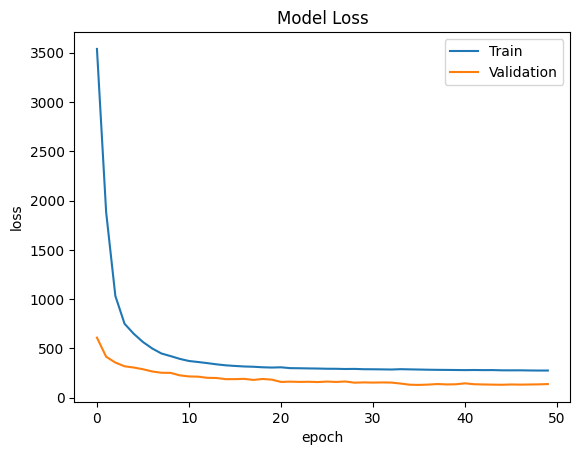

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
compare_model.save("model/air_compare_model.keras")

# **validation_test_compare**

In [ ]:
compare_model = load_model('model/air_compare_model.keras')

In [ ]:
predictions = compare_model.predict(X_test)

mae_per_feature_per_sensor = np.mean(np.abs(y_test - predictions), axis=0)
rmse_per_feature_per_sensor = np.sqrt(np.mean((y_test - predictions)**2, axis=0))

with open("error/error_metrics_2.txt", "w") as f:
    for i, (mae, rmse) in enumerate(zip(mae_per_feature_per_sensor, rmse_per_feature_per_sensor)):
        f.write(f"Sensor {i + 1} - Error Metrics per feature:\n")
        f.write(f"  PM10 MAE:       {mae[0]:.2f}   RMSE: {rmse[0]:.2f}\n")
        f.write(f"  PM25 MAE:       {mae[1]:.2f}   RMSE: {rmse[1]:.2f}\n")
        f.write(f"  Temperature MAE: {mae[2]:.2f}   RMSE: {rmse[2]:.2f}\n")
        f.write(f"  Humidity MAE:   {mae[3]:.2f}   RMSE: {rmse[3]:.2f}\n\n")

    overall_mae = np.mean(mae_per_feature_per_sensor, axis=0)
    overall_rmse = np.mean(rmse_per_feature_per_sensor, axis=0)

    f.write("Overall Error Metrics per feature:\n")
    f.write(f"  PM10 MAE:       {overall_mae[0]:.2f}   RMSE: {overall_rmse[0]:.2f}\n")
    f.write(f"  PM25 MAE:       {overall_mae[1]:.2f}   RMSE: {overall_rmse[1]:.2f}\n")
    f.write(f"  Temperature MAE: {overall_mae[2]:.2f}   RMSE: {overall_rmse[2]:.2f}\n")
    f.write(f"  Humidity MAE:   {overall_mae[3]:.2f}   RMSE: {overall_rmse[3]:.2f}\n")

# Print the content of the file
with open("error/error_metrics_2.txt", "r") as f:
    print(f.read())

9/9 [==============================] - 0s 5ms/step
Sensor 1 - Error Metrics per feature:
  PM10 MAE:       22.31   RMSE: 29.22
  PM25 MAE:       21.28   RMSE: 27.66
  Temperature MAE: 4.63   RMSE: 6.16
  Humidity MAE:   9.05   RMSE: 10.54

Sensor 2 - Error Metrics per feature:
  PM10 MAE:       11.13   RMSE: 14.56
  PM25 MAE:       8.76   RMSE: 11.25
  Temperature MAE: 3.53   RMSE: 4.18
  Humidity MAE:   9.77   RMSE: 11.92

Sensor 3 - Error Metrics per feature:
  PM10 MAE:       13.61   RMSE: 17.14
  PM25 MAE:       9.06   RMSE: 11.88
  Temperature MAE: 3.42   RMSE: 4.18
  Humidity MAE:   3.91   RMSE: 5.40

Sensor 4 - Error Metrics per feature:
  PM10 MAE:       12.23   RMSE: 15.87
  PM25 MAE:       8.03   RMSE: 10.45
  Temperature MAE: 2.70   RMSE: 3.35
  Humidity MAE:   6.51   RMSE: 8.70

Sensor 5 - Error Metrics per feature:
  PM10 MAE:       11.62   RMSE: 14.78
  PM25 MAE:       8.10   RMSE: 10.24
  Temperature MAE: 2.16   RMSE: 2.80
  Humidity MAE:   6.05   RMSE: 7.26

Sensor 6 - 

# **compare_model_data195**

In [ ]:
def sprite_data_1point(file_path, train_hour, test_hour, test_period, stride):
    # Load data
    df_temp = pd.read_csv(file_path)
    
    # Extract features and target
    df_x = df_temp[['pm10', 'pm25', 'temp', 'humid']].to_numpy()
    df_y = df_temp[['pm10', 'pm25', 'temp', 'humid']].to_numpy()

    # Initialize lists to store input (x) and output (y) sequences
    x, y = [], []
    
    # Calculate total period length
    period = train_hour + test_period + test_hour
    
    # Check for infinite loop
    assert stride != 0
    
    # Initialize loop index
    i = 0
    
    # Iterate over the data
    while i + period <= len(df_x):
        # Append input sequence (x)
        x.append(np.array(df_x[i:i + train_hour]))
        # Append output sequence (y)
        y.append(df_y[i + train_hour + test_period:i + train_hour + test_period + test_hour].flatten())
        # Move the index by stride
        i += stride
    
    return np.array(x),np.array(y)


In [ ]:
file_path = os.path.join("RE1.1", "data_195.csv")
X_train, y_train = sprite_data_1point(file_path, train_hour=6, test_hour=1, test_period=24, stride=1)

In [ ]:
file_path = os.path.join("RE1.2", "data_195.csv")
X_test, y_test = sprite_data_1point(file_path, train_hour=6, test_hour=1, test_period=24, stride=1)

In [ ]:
time_step = X_train.shape[1]
input_dim =  X_train.shape[2]
out =  y_train.shape[1]

compare_1point_model = Sequential()
compare_1point_model.add((LSTM(24,activation='relu', input_shape=(time_step, input_dim),return_sequences=False)))
compare_1point_model.add(Dense(out))
compare_1point_model.compile(loss='mse', optimizer='adam')
print(f'Data size for features {X_train.shape} and labels {y_train.shape}')
print(f'input shape = {X_train.shape}')
callback = callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1)

hist = compare_1point_model.fit(X_train, y_train,epochs=50, validation_split=.2,verbose=1, batch_size=24, callbacks=[callback], shuffle=False)

compare_1point_model.summary()

Data size for features (8731, 6, 4) and labels (8731, 4)
input shape = (8731, 6, 4)
Epoch 1/50


291/291 [==============================] - 3s 8ms/step - loss: 2595.3401 - val_loss: 108.2895
Epoch 2/50
291/291 [==============================] - 1s 5ms/step - loss: 391.8219 - val_loss: 111.9598
Epoch 3/50
291/291 [==============================] - 1s 5ms/step - loss: 308.1714 - val_loss: 103.0844
Epoch 4/50
291/291 [==============================] - 2s 6ms/step - loss: 312.8616 - val_loss: 102.0782
Epoch 5/50
291/291 [==============================] - 2s 6ms/step - loss: 302.8667 - val_loss: 101.0756
Epoch 6/50
291/291 [==============================] - 2s 5ms/step - loss: 294.2671 - val_loss: 107.6423
Epoch 7/50
291/291 [==============================] - 1s 5ms/step - loss: 296.9432 - val_loss: 92.2441
Epoch 8/50
291/291 [==============================] - 1s 5ms/step - loss: 290.3587 - val_loss: 92.9173
Epoch 9/50
291/291 [==============================] - 1s 5ms/step - loss: 285.4303 - val_loss: 85.0405
Epoch 10/50
291/291 [==============================] - 1s 5ms/step - loss: 27

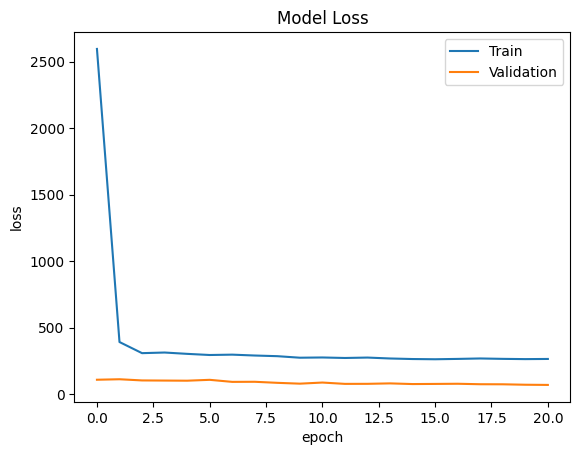

In [ ]:
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
compare_1point_model.save("model/air_compare_1point_model.keras")

In [ ]:
compare_1point_model = load_model('model/air_compare_1point_model.keras')

In [ ]:
predictions = compare_1point_model.predict(X_test)

MAE = np.mean(np.abs(y_test - predictions), axis=0)
RMSE = np.sqrt(np.mean((y_test - predictions)**2, axis=0))

with open("error/error_metrics_1point.txt", "w") as f:

    f.write("Overall Error Metrics per feature:\n")
    f.write(f"  PM10 MAE:       {MAE[0]:.2f}   RMSE: {RMSE[0]:.2f}\n")
    f.write(f"  PM25 MAE:       {MAE[1]:.2f}   RMSE: {RMSE[1]:.2f}\n")
    f.write(f"  Temperature MAE: {MAE[2]:.2f}   RMSE: {RMSE[2]:.2f}\n")
    f.write(f"  Humidity MAE:   {MAE[3]:.2f}   RMSE: {RMSE[3]:.2f}\n")

# Print the content of the file
with open("error/error_metrics_1point.txt", "r") as f:
    print(f.read())

9/9 [==============================] - 0s 3ms/step
Overall Error Metrics per feature:
  PM10 MAE:       11.91   RMSE: 15.29
  PM25 MAE:       8.50   RMSE: 11.09
  Temperature MAE: 3.02   RMSE: 3.58
  Humidity MAE:   11.02   RMSE: 13.07

